# Looking into different death models

In [1]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import copy
import theano

%matplotlib inline

In [14]:
new_deaths = np.logspace(-5, 5, 100, base=np.e)
new_deaths[new_deaths < 1] = 0
new_deaths = np.ceil(new_deaths)

print(f"The true log growth rate is {10/100}")

The true log growth rate is 0.1


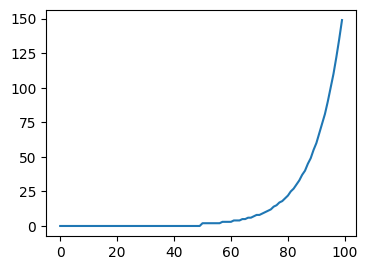

In [15]:
plt.figure(figsize=(4, 3), dpi=100)
plt.plot(new_deaths)

The model uses actual deaths to reverse calculated expected deaths, effectively. We can assume that expected deaths growths exponentially (assuming that we are at the start of teh pandemic)

In [16]:
N_days = 100
new_deaths_logmodel = copy.deepcopy(new_deaths)
no_death_offset = 1e-3
new_deaths_logmodel += no_death_offset

with pm.Model() as logmodel:
    log_growth_rate = T.ones(N_days) * pm.Normal("log_growth_rate", 0, 0.5)
    log_n0 = pm.Normal("log_n0", -3, 1)
    log_num_infected = pm.Deterministic("log_num_infected", log_n0 + log_growth_rate.cumsum())
    num_infected = pm.Deterministic("num_infected", pm.math.exp(log_num_infected))
    
    # lognorm output
    observed = pm.Normal("Observed", log_num_infected, sigma=0.3, observed=np.log(new_deaths_logmodel))

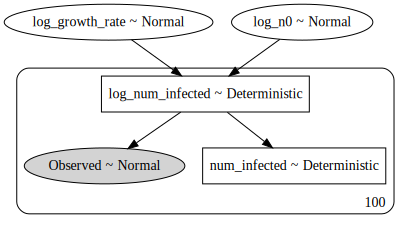

In [17]:
pm.model_to_graphviz(logmodel)

In [18]:
with logmodel:
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_n0, log_growth_rate]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1993.53draws/s]
The acceptance probability does not match the target. It is 0.9319240911933763, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.949803894191614, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9570409727761864, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8889362063161858, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [19]:
def produce_CIs(data):
    means = np.mean(data, axis=0)
    li = np.percentile(data, 2.5, axis=0)
    ui = np.percentile(data, 97.5, axis=0)
    err = np.array([means - li, ui - means])
    return means, li, ui, err

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13da2e410>,
      dtype=object)

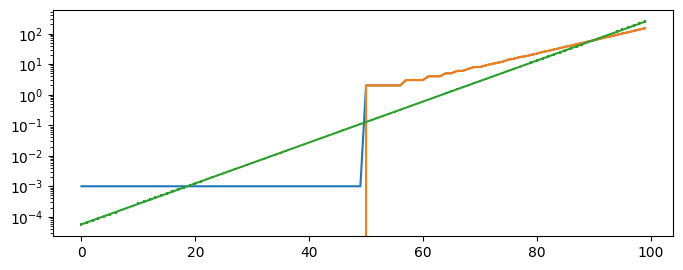

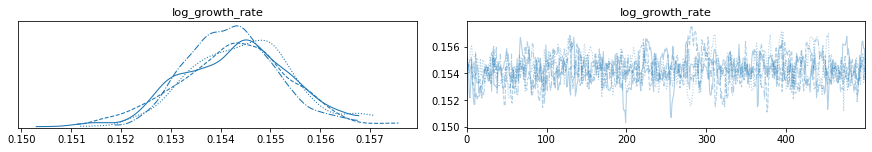

In [20]:
means, _, _, err = produce_CIs(trace["num_infected"])

plt.figure(figsize=(8, 3), dpi=100)
plt.semilogy(new_deaths_logmodel)
plt.semilogy(new_deaths)
plt.errorbar(np.arange(new_deaths_logmodel.size), means, yerr=err)

pm.traceplot(trace, "log_growth_rate")

# adding an offset

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_n0, log_growth_rate]
Sampling 4 chains, 17 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1467.45draws/s]
The acceptance probability does not match the target. It is 0.9615728799936865, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
No handles with labels found to put in legend.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13b6cf390>,
      dtype=object)

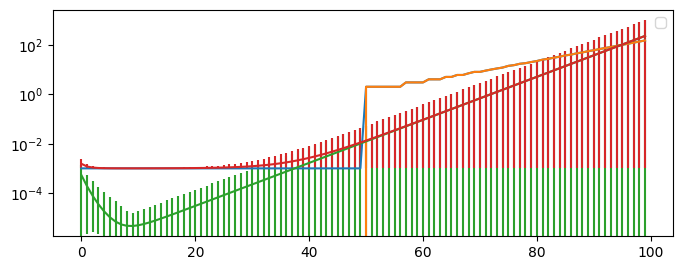

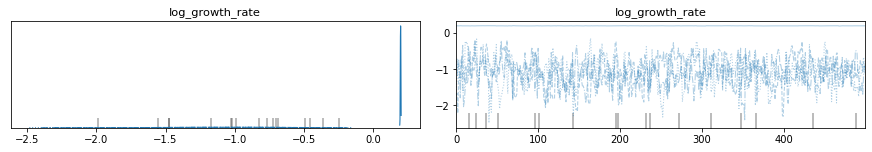

In [21]:
N_days = 100
new_deaths_logmodel = copy.deepcopy(new_deaths)
no_death_offset = 1e-3
new_deaths_logmodel[new_deaths_logmodel < 1] = no_death_offset

with pm.Model() as logmodel:
    log_growth_rate = T.ones(N_days) * pm.Normal("log_growth_rate", 0, 0.5)
    log_n0 = pm.Normal("log_n0", -3, 1)
    log_num_infected = pm.Deterministic("log_num_infected", log_n0 + log_growth_rate.cumsum())
    num_infected = pm.Deterministic("num_infected", pm.math.exp(log_num_infected))
    num_infected_offset = pm.Deterministic("num_infected_offset", pm.math.exp(log_num_infected) + no_death_offset)
    
    # lognorm output
    observed = pm.Normal("Observed", pm.math.log(num_infected_offset), sigma=0.3, observed=np.log(new_deaths_logmodel))
    
with logmodel:
    trace = pm.sample(500)

means, _, _, err = produce_CIs(trace["num_infected"])
means_offset, _, _, err_offset = produce_CIs(trace["num_infected_offset"])

plt.figure(figsize=(8, 3), dpi=100)
plt.semilogy(new_deaths_logmodel)
plt.semilogy(new_deaths)
plt.errorbar(np.arange(new_deaths_logmodel.size), means, yerr=err)
plt.errorbar(np.arange(new_deaths_logmodel.size), means_offset, yerr=err_offset)
plt.legend()

pm.traceplot(trace, "log_growth_rate")

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Observed_missing, log_n0, log_growth_rate]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:18<00:00, 211.80draws/s]
The acceptance probability does not match the target. It is 0.8858953349411663, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8943404394064304, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
No handles with labels found to put in legend.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13cc2e0d0>,
      dtype=object)

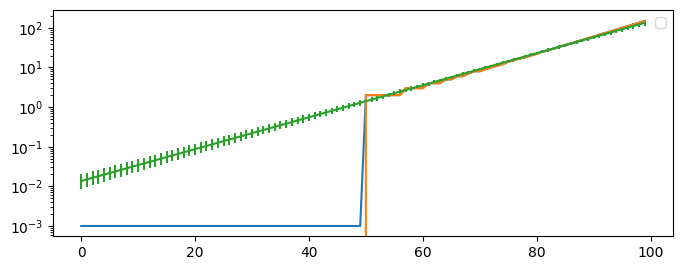

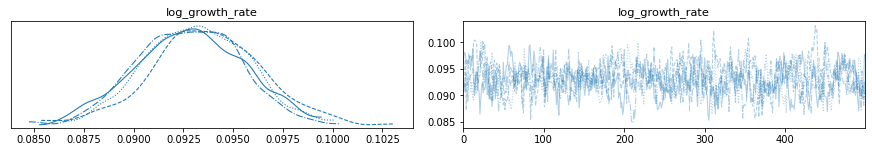

In [22]:
N_days = 100
new_deaths_masked_model = copy.deepcopy(new_deaths)
new_deaths_masked_model[new_deaths_masked_model < 1] = np.nan
new_deaths_masked_model = np.ma.masked_invalid(new_deaths_masked_model.astype(theano.config.floatX))

with pm.Model() as masked_model:
    log_growth_rate = T.ones(N_days) * pm.Normal("log_growth_rate", 0, 0.5)
    log_n0 = pm.Normal("log_n0", -3, 1)
    log_num_infected = pm.Deterministic("log_num_infected", log_n0 + log_growth_rate.cumsum())
    num_infected = pm.Deterministic("num_infected", pm.math.exp(log_num_infected))
    
    # lognorm output
    observed = pm.Normal("Observed", pm.math.log(num_infected), sigma=0.3, observed=np.log(new_deaths_masked_model))
    
with masked_model:
    trace = pm.sample(500)

means, _, _, err = produce_CIs(trace["num_infected"])

plt.figure(figsize=(8, 3), dpi=100)
plt.semilogy(new_deaths_logmodel)
plt.semilogy(new_deaths)
plt.errorbar(np.arange(new_deaths_logmodel.size), means, yerr=err)
plt.legend()

pm.traceplot(trace, "log_growth_rate")

Of the methods we have tried, this is the one which has worked best .... 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_n0, log_growth_rate]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 727.72draws/s] 
The acceptance probability does not match the target. It is 0.8927604208840286, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
No handles with labels found to put in legend.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13b801850>,
      dtype=object)

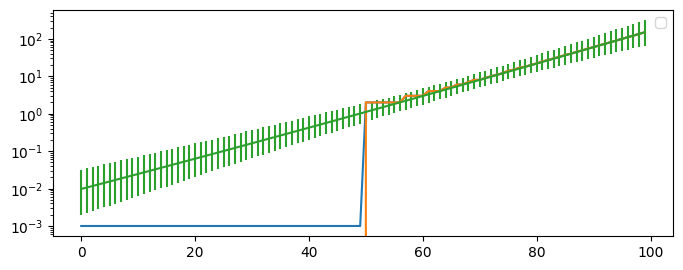

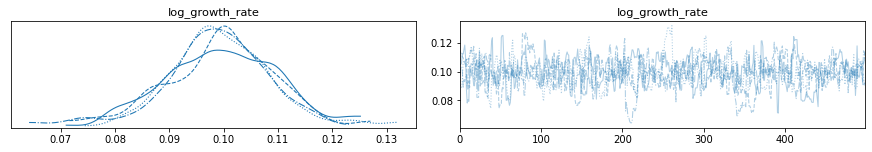

In [23]:
N_days = 100
new_deaths_negative_binomial = copy.deepcopy(new_deaths)


with pm.Model() as nb_model:
    log_growth_rate = T.ones(N_days) * pm.Normal("log_growth_rate", 0, 0.5)
    log_n0 = pm.Normal("log_n0", -3, 1)
    log_num_infected = pm.Deterministic("log_num_infected", log_n0 + log_growth_rate.cumsum())
    num_infected = pm.Deterministic("num_infected", pm.math.exp(log_num_infected))
    
    # lognorm output
    observed = pm.NegativeBinomial("Observed", mu=num_infected, alpha=0.3, observed=new_deaths_negative_binomial)
    
with nb_model:
    trace = pm.sample(500)

means, _, _, err = produce_CIs(trace["num_infected"])

plt.figure(figsize=(8, 3), dpi=100)
plt.semilogy(new_deaths_logmodel)
plt.semilogy(new_deaths)
plt.errorbar(np.arange(new_deaths_logmodel.size), means, yerr=err)
plt.legend()

pm.traceplot(trace, "log_growth_rate")

This one also worked well.

target mean: 10 var: 20.0
pmf mean: 10.000000000000004 pmf var: 20.000000000000014


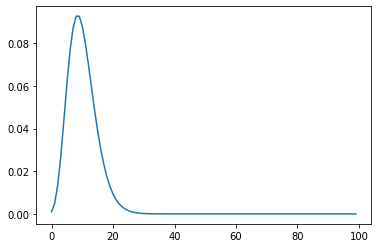

In [24]:
target_mean = 10
Phi = 10
target_var = 10 + ((10 ** 2) / (Phi))

print(f"target mean: {target_mean} var: {target_var}")

x_vals = np.arange(100)
d = pm.NegativeBinomial.dist(mu=target_mean, alpha=Phi)
pmf = np.exp(d.logp(x_vals).eval())
plt.plot(x_vals, pmf)

pmf_mean = np.sum([k * pmf[k] for k in range(len(x_vals))])
pmf_var = np.sum([(k**2) * pmf[k] for k in range(len(x_vals))]) - pmf_mean**2
print(f"pmf mean: {pmf_mean} pmf var: {pmf_var}")

In [25]:
pmf**2

array([9.53674316e-07, 2.38418579e-05, 1.80304050e-04, 7.21216202e-04,
       1.90446153e-03, 3.73274460e-03, 5.83241344e-03, 7.61784613e-03,
       8.59983411e-03, 8.59983411e-03, 7.76135028e-03, 6.41433908e-03,
       4.91097836e-03, 3.51614427e-03, 2.37250040e-03, 1.51840026e-03,
       9.26757971e-04, 5.41944972e-04, 3.04844047e-04, 1.65510895e-04,
       8.69966643e-05, 4.43860532e-05, 2.20325399e-05, 1.06622499e-05,
       5.03957906e-06, 2.33030136e-06, 1.05570235e-06, 4.69201046e-07,
       2.04826604e-07, 8.79220026e-08, 3.71470461e-08, 1.54618298e-08,
       6.34554099e-09, 2.56968189e-09, 1.02753932e-09, 4.05982882e-10,
       1.58587063e-10, 6.12801728e-11, 2.34362711e-11, 8.87527425e-12,
       3.32961460e-12, 1.23795903e-12, 4.56339489e-13, 1.66839099e-13,
       6.05179532e-14, 2.17864632e-14, 7.78639545e-15, 2.76348304e-15,
       9.74235720e-16, 3.41246247e-16, 1.18787819e-16, 4.11030515e-17,
       1.41405746e-17, 4.83769746e-18, 1.64616094e-18, 5.57245885e-19,
      